<a href="https://colab.research.google.com/github/ftk1000/1_deep_learn_class/blob/main/rnn_imdb_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Mar 18 21:15:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

2023.03.05

rnn_imdb_reviews.ipynb

# 2023-Spring-BUAN-6382.501, Applied Deep Learning

Modified from the original source:

Ref: https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb#scrollTo=hX4n9TsbGw-f

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [3]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

def sigmoid(z):
    return 1/(1 + np.exp(-z))

Import `matplotlib` and create a helper function to plot graphs:

In [4]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [5]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [6]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [8]:
%%time
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

CPU times: user 11.9 ms, sys: 1.04 ms, total: 12.9 ms
Wall time: 14.4 ms


In [9]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Ok - I admit. I think Kenny Doughty looks amazing in this movie - but beyond his good looks, the movie is carried by a sometimes predictable, but reasonable plot.<br /><br />Starting out, we\'re introduced to the three lead females of the movie. One a headmistress - very concerned about her image and never married. A police officer - with child and a bad ex to go on about. The third - a power & status hungry doctor with a desire for recognition and three ex\'s.<br /><br />They are almost the "First Wives Club", and indeed there is much verbal bashing of ex\'s involved as well as some "he left the credit card" behaviour. Characters set - the movie continues.<br /><br />McDowell\'s character, the headmistress, arrives late at a funeral - where a young organist, filling in for the regular player (Doughty) catches her eye. What will her two friends say about the ensuing mischief? Will they live happily ever after?<br /><br />A tissue or two recommended if you\'re the teary type 

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [10]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [11]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [12]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[597,  10, 934, ...,   0,   0,   0],
       [ 11,  18,  60, ...,   0,   0,   0],
       [  1,  10,  59, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [13]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Ok - I admit. I think Kenny Doughty looks amazing in this movie - but beyond his good looks, the movie is carried by a sometimes predictable, but reasonable plot.<br /><br />Starting out, we\'re introduced to the three lead females of the movie. One a headmistress - very concerned about her image and never married. A police officer - with child and a bad ex to go on about. The third - a power & status hungry doctor with a desire for recognition and three ex\'s.<br /><br />They are almost the "First Wives Club", and indeed there is much verbal bashing of ex\'s involved as well as some "he left the credit card" behaviour. Characters set - the movie continues.<br /><br />McDowell\'s character, the headmistress, arrives late at a funeral - where a young organist, filling in for the regular player (Doughty) catches her eye. What will her two friends say about the ensuing mischief? Will they live happily ever after?<br /><br />A tissue or two recommended if you\'re the teary typ

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model.

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

In [16]:
# tf.keras.layers.Embedding(
#     input_dim=len(encoder.get_vocabulary()),
#     output_dim=64,
#     # Use masking to handle the variable sequence lengths
#     mask_zero=True)

In [17]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [18]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [21]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

sample_text = ('The movie was terrible. I do not recommend this movie.')

predictions = model.predict(np.array([sample_text]))


print(predictions[0])

1/1 [==============================] - 0s 19ms/step
[0.50106925]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [22]:
# predict on a sample text with padding

padding = "the " * 2000
padded_sample_text = np.array([sample_text, padding])
print(f'padded_sample_text= {padded_sample_text}')

print('run prediction ...')
predictions = model.predict(padded_sample_text)
print(predictions[0])

padded_sample_text= ['The movie was terrible. I do not recommend this movie.'
 'the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 

In [23]:
predictions

array([[0.50106925],
       [0.5017001 ]], dtype=float32)

In [24]:
sigmoid(predictions)

array([[0.6227106 ],
       [0.62285876]], dtype=float32)

Compile the Keras model to configure the training process:

In [25]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [26]:
%%time
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


391/391 [==============================] - 50s 104ms/step - loss: 0.6491 - accuracy: 0.6197 - val_loss: 0.4871 - val_accuracy: 0.7870
Epoch 2/10
391/391 [==============================] - 27s 68ms/step - loss: 0.4038 - accuracy: 0.8272 - val_loss: 0.3659 - val_accuracy: 0.8448
Epoch 3/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3422 - accuracy: 0.8558 - val_loss: 0.3490 - val_accuracy: 0.8516
Epoch 4/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3253 - accuracy: 0.8644 - val_loss: 0.3479 - val_accuracy: 0.8516
Epoch 5/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3157 - accuracy: 0.8679 - val_loss: 0.3341 - val_accuracy: 0.8547
Epoch 6/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3097 - accuracy: 0.8726 - val_loss: 0.3605 - val_accuracy: 0.8484
Epoch 7/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3061 - accuracy: 0.8726 - val_loss: 0.3235 - val_accuracy: 0.8641
Ep

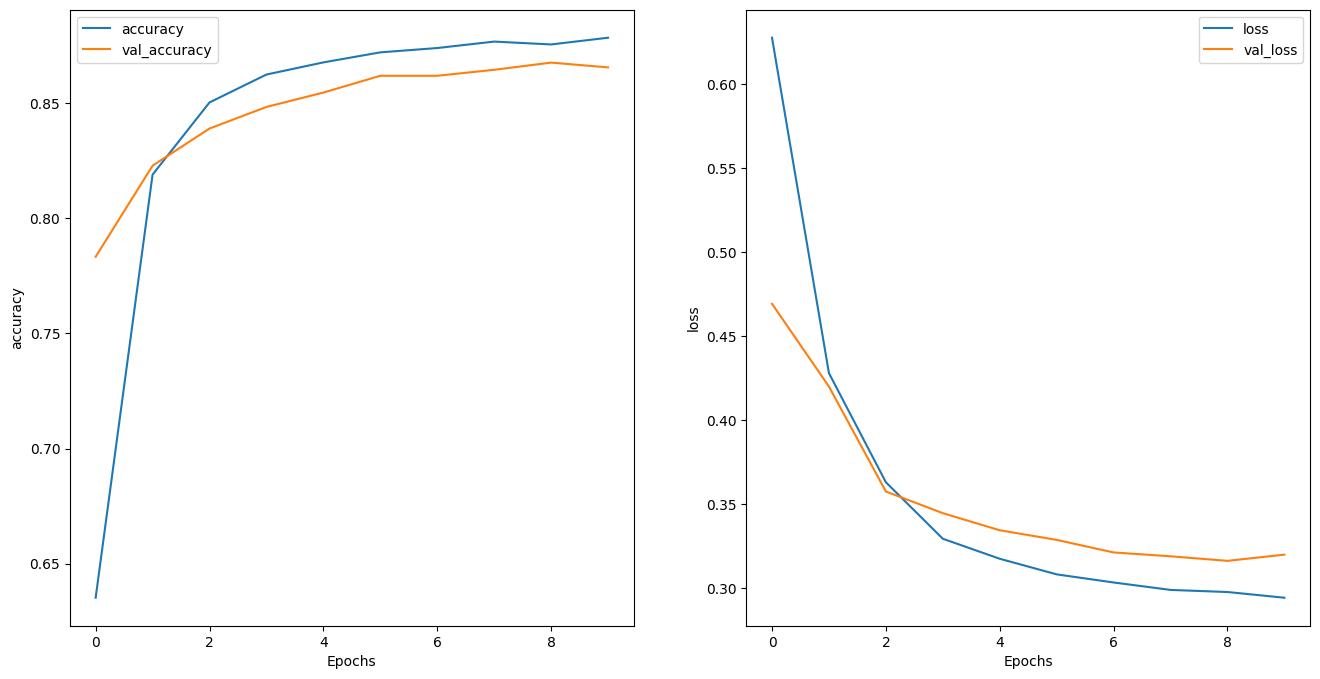

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
# plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
# plt.ylim(0, None)

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 30ms/step - loss: 0.3181 - accuracy: 0.8623
Test Loss: 0.3181302547454834
Test Accuracy: 0.8623200058937073


Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


In [ ]:
predictions

array([[0.6972294]], dtype=float32)

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
%%time
history = model.fit(train_dataset, epochs=20,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/20
391/391 [==============================] - 83s 157ms/step - loss: 0.6115 - accuracy: 0.6528 - val_loss: 0.4195 - val_accuracy: 0.8214
Epoch 2/20
391/391 [==============================] - 47s 120ms/step - loss: 0.3867 - accuracy: 0.8377 - val_loss: 0.3485 - val_accuracy: 0.8510
Epoch 3/20
391/391 [==============================] - 48s 122ms/step - loss: 0.3357 - accuracy: 0.8619 - val_loss: 0.3316 - val_accuracy: 0.8667
Epoch 4/20
391/391 [==============================] - 47s 120ms/step - loss: 0.3165 - accuracy: 0.8702 - val_loss: 0.3174 - val_accuracy: 0.8667
Epoch 5/20
391/391 [==============================] - 46s 117ms/step - loss: 0.3101 - accuracy: 0.8725 - val_loss: 0.3181 - val_accuracy: 0.8656
Epoch 6/20
391/391 [==============================] - 46s 118ms/step - loss: 0.3070 - accuracy: 0.8735 - val_loss: 0.3161 - val_accuracy: 0.8625
Epoch 7/20
391/391 [==============================] - 47s 119ms/step - loss: 0.3031 - accuracy: 0.8749 - val_loss: 0.3187 - val_ac

In [27]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 13s 33ms/step - loss: 0.3217 - accuracy: 0.8619
Test Loss: 0.32172244787216187
Test Accuracy: 0.8619199991226196


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 0s 27ms/step
[[0.1076759]]


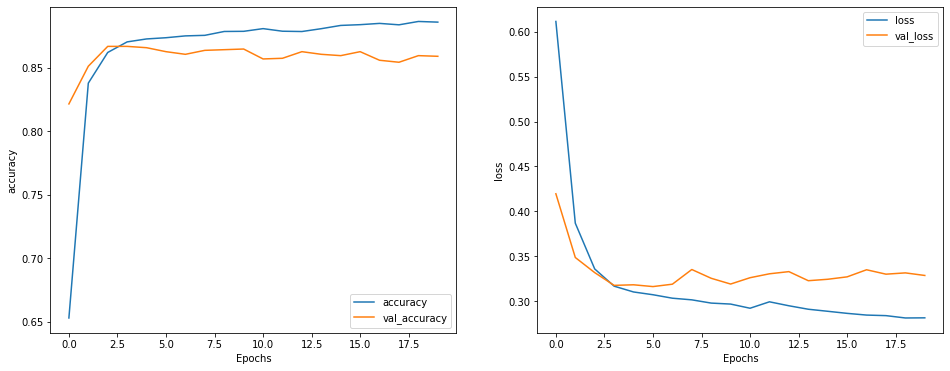

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).


In [ ]:
Reference: BUAN 6382.SW1.S24 course by Dr Farid Khafizov at Naveen Jindal School to Management, UTDallas.